## Matheus Fernandes, Pedro Faustini

## 1. Introdução

Este trabalho estuda técnicas de mineração de dados para classificar áudio. Em específico, o universo a ser classificado consiste em dez caracteres: 6, 7, a, b, c, d, h, m, n, x. Cada arquivo de áudio, chamado de _captcha_, contém 4 caracteres, podendo haver repetição. A classificação de um _captcha_ é considerada sucesso somente se **todos** os seus quatro caracteres são corretamente identificados.

Para este trabalho foram utilizadas as ferramentas mencionadas abaixo.

- FFMPEG
- Anaconda (Python>=3.5) 
- numpy>=1.13.3
- pandas>=0.20.3
- scikit-learn>=0.19.1
- scipy==1.1.0 
- librosa>=0.6.1
- matplotlib>=1.5.3
- ipython>=6.2.1
- Sox (`conda install -c conda-forge sox`)

Numpy e Pandas manipulam vetores de uma forma mais otimizada e rica em informação em relação à classe _list_ padrão do Python. Scikit-learn implementa algoritmos de mineração de dados, como classificadores e técnicas de transformação. Scipy é uma biblioteca usada para computação científica. Matplotlib fornece funções para plotar imagens e gráficos. Por fim, librosa é uma biblioteca para manipulação de áudio. Também incluímos aos arquivos a biblioteca `pysndfx`, que nada mais é do que um *wrapper* para o Sox. Ela está disponível no [Github](https://github.com/carlthome/python-audio-effects).

In [28]:
from IPython.display import display

## 2. Análise exploratória

A primeira tarefa é criar a estrutura de pastas necessárias e segmentar os _captchas_. Como cada _captcha_ contém quatro caracteres, a ideia é gerar um arquivo `.wav` para cada caractere.

In [29]:
from main import create_folder_structure
create_folder_structure()

### 2.1 Segmentação

A segmentação, feita pelo módulo *preprocessor.py* segue os passos:

- O áudio é normalizado (tornando o maior pico = 1). Um _limiter_ é aplicado com o parâmetro de 20dB, de modo a reduzir a diferença entre picos altos e baixos, pois nem todas as letras são gravadas com a mesma intensidade;
- Frequências fora do intervalo 100-2500Hz são descartadas, pois têm pouca informação vocal. Então, um equalizador é aplicado na faixa de 300Hz, intensificando essas frequências. Instensidades menores que 0.5 são zeradas, a fim de remover ruído de gravação. Na prática, tentamos aproximar uma binarização entre fala e silêncio;
- Usa-se a função `find_peaks`, da biblioteca `scipy.signal`, para encontrar os picos. Mesmo com bons parâmetros, por vezes a função encontra mais do que 4 picos, chamados daqui em diante de pontos;
- Queremos que cada ponto represente um caractere. São escolhidos os pares de pontos mais próximos um do outro, e ambos são removidos e substituídos pela sua média. Isso é feito até que restem apenas 4 pontos. Teoricamente, ao fazer isso estamos pegando os caracteres com mais de um pico e colapsando suas posições até restar apenas um ponto, próximo ao seu centro;
- A partir de cada ponto encontrado, é extraída do áudio original uma região de 1s para cada lado, totalizando no máximo 2s de áudio. O ruído de fundo (silêncio) de cada lado é removido, isolando apenas a fala, e, como essa operação normalmente remove o começo e final do caractere, 0.25s são adicionados de volta de cada lado;
- Os áudios encontrados são exportados, assumindo que foram encontrados na ordem em que estão presentes no nome do arquivo.


Na imagem abaixo, desenhamos as ondas de um exemplo da base de treinamento. A onda laranja representa o áudio original; a onda roxa mostra o áudio após feito o processamento. Pode-se notar que os picos estão bem mais visíveis, e as regiões de ruído de fundo tornaram-se silêncio; dessa forma, temos um áudio próximo de "binarizado". Os riscos em preto são os quatro pontos encontrados.

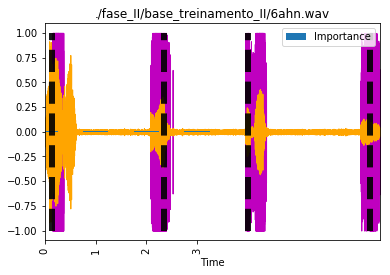

In [30]:
import preprocessor as trim
trim.trim('./fase_II/base_treinamento_II/6ahn.wav', '', True) #desenha o grafico

### 2.2 Atributos e análise preliminar de classificadores

In [31]:
from model import train, individual_classifiers_results, test, get_final_model, final_test

In [32]:
from display_results import resultados_acuracia, resultados_caracteres

As funções relacionadas aos atributos estão no módulo *transformation.py*. Já os classificadores, no módulo *model.py*.

A função `_get_spectrum` extrai a intensidade média dentro de cada um dos [espectros de áudio](https://www.teachmeaudio.com/mixing/techniques/audio-spectrum/). Por exemplo, os espectros mais agudos poderiam ajudar um classificador a separar caracteres sibilantes (com sons de "S", como x e 7) de caracteres não sibilantes (como m e h). A função *_get_peaks*  conta os picos no áudios.

Com o auxílio da biblioteca *librosa*, extraímos o [MFCC](https://www.maxwell.vrac.puc-rio.br/23090/23090_4.PDF) (Mel-Frequency Cepstral Coefficients) das ondas sonoras. Para cada áudio, o MFCC retornado é uma matriz, onde cada linha possui um vetor numérico. O MFCC procura imitar as características que seres humanos percebem pelo ouvido. Para não lidar com um número absurdamente grande de atributos, usamos somente a mediana e o desvio padrão de cada vetor (40 ao todo), cujos valores foram tornados positivos. Isso foi feito porque os vetores do MFCC continham valores negativos e positivos (ondas), e assim a mediana tenderia a ser sempre próxima de zero.

Além disso, também com o auxílio da *librosa*, contamos quantas vezes o áudio corta o zero no eixo y, dividido pelo tamanho do áudio, a fim de ter um valor normalizado. Também extraímos o RMS dos áudios e usamos o desvio padrão, média e a mediana como atributo. O RMS funciona como uma média para os picos do áudio. Ainda com o auxílio da librosa, extraímos média e desvio padrão de *spectral_contrast*.

A função `extract_features` agrega os atributos acima citados em um vetor com 95 *features* ao todo. Os dados são normalizados de forma a terem média 0 e desvio 1. Isso é importante principalmente para algoritmos baseados em distância, de forma que atributos com valores maiores não dominem a classificação em detrimento de outros cujos valores tendem a ser mais próximos de zero. Os resultados preliminares de cada classificador se encontram abaixo. Foi usada a base de treinamento fornecida para treino e a base de validação fornecida para teste.

In [33]:
X_train, y_train, std_scale = train()

In [34]:
captchas_svm, caracteres_svm, captchas_1nn, caracteres_1nn, captchas_3nn, caracteres_3nn, captchas_lda, caracteres_lda, elementos, corretos_svm,corretos_1nn, errados_svm,errados_1nn, corretos_lda,corretos_3nn, errados_lda,errados_3nn = individual_classifiers_results(X_train, y_train, std_scale)

In [35]:
display(resultados_acuracia("classificadores", [[("Acuracia SVM (captcha)", "{0:.2f}".format(captchas_svm)), ("Acuracia SVM (caracteres)", "{0:.2f}".format(caracteres_svm)) ],[("Acuracia LDA (captcha)", "{0:.2f}".format(captchas_lda)), ("Acuracia LDA (caracteres)", "{0:.2f}".format(caracteres_lda)) ],[("Acuracia 3NN (captcha)", "{0:.2f}".format(captchas_3nn)), ("Acuracia 3NN (caracteres)", "{0:.2f}".format(caracteres_3nn)) ],[("Acuracia 1NN (captcha)", "{0:.2f}".format(captchas_1nn)), ("Acuracia 1NN (caracteres)", "{0:.2f}".format(caracteres_1nn)) ]]))

#### Acurácia classificadores
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia SVM (captcha)| 15.44%|
|Acuracia SVM (caracteres)| 59.63%|
|Acuracia LDA (captcha)| 13.42%|
|Acuracia LDA (caracteres)| 60.98%|
|Acuracia 3NN (captcha)| 3.36%|
|Acuracia 3NN (caracteres)| 49.32%|
|Acuracia 1NN (captcha)| 8.72%|
|Acuracia 1NN (caracteres)| 54.05%|

## 3. Metodologia

Para cada caso, é calculada a acurácia na detecção de caracteres e _captchas_. Os algoritmos usados, conforme já mencionado, são 1NN, 3NN, LDA e SVM.

- **KNN**: O algoritmo recebe um elemento de teste e calcula sua distância para os demais elementos na base de dados. O elemento de teste recebe a classe do elemento mais próximo. No presente caso, foi usada a distância euclidiana, com valores de k igual a 1 e 3 (ver apêndice nos testes de K realizados).

- **SVM**: O _Support Vector Machine_, a partir de uma base de dados com elementos rotulados, constrói um modelo de pontos em um espaço de forma que cada classe esteja no espaço mais amplo possível. Então, ele traça retas, e os elementos são classificados conforme o local em que são colocados.
    
- **LDA**: O _Linear Discriminant Analysis_ possui uma fronteira de decisão linear. O modelo é treinado por meio de de gaussianas geradas para cada classe.

Foi usada a base de treinamento fornecida para treino e a base de validação fornecida para teste. Os melhores resultados foram obtidos por LDA e SVM, conforme mostra a Seção 2. Então realizamos um *ensemble* usando maioria de votos. Como a acurácia de caracteres do LDA foi a mais alta, deixamos o seu resultado com peso 2 na contagem de votos, e os demais com peso 1.

## 4. Resultados

No apêndice (6.1) há ainda a acurácia na detecção de cada caracter individualmente

In [36]:
accuracy_captcha, accuracy_character, wrong, correct, elements = test(X_train, y_train, std_scale)

In [37]:
display(resultados_acuracia("", [[("Acuracia (captcha)", "{0:.2f}".format(accuracy_captcha)), ("Acuracia (caracteres)", "{0:.2f}".format(accuracy_character)) ]]))

#### Acurácia 
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia (captcha)| 19.46%|
|Acuracia (caracteres)| 63.85%|

A acurácia obtida na detecção de _captchas_ não está muito distante do previsto, com base na acurácia individual de detecção de caracteres. A afirmação vem da suposição de que um classificador que obtenha 63.85% de acurácia para os caracteres tende, ao classificar um _captcha_ com quatro caracteres, obteria: 

$$0.6385 \cdot 0.6385 \cdot 0.6385 \cdot 0.6385 = 0.6385^4 = 16.62\%$$

Nossos testes chegaram a 19.46% de acerto.

A linha abaixo retorna o modelo final, que usa as bases de treino + validação para treinar um modelo a ser usado contra a base de teste.

In [38]:
final_classifier, std_scale = get_final_model()

A linha abaixo executa o modelo

In [39]:
accuracy_captcha_final, accuracy_character_final, wrong_final, correct_final, elements_final = final_test(std_scale, final_classifier)

In [ ]:
display(resultados_caracteres("Resultados finais", correct_final, wrong_final, elements_final))

In [ ]:
display(resultados_acuracia("", [[("Acuracia (captcha)", "{0:.2f}".format(accuracy_captcha_final)), ("Acuracia (caracteres)", "{0:.2f}".format(accuracy_character_final)) ]]))

## 5. Comentários finais

- Dificuldades encontradas: A segmentação não foi um processo trivial. Separar o áudio em faixas de tempo pré-determinadas era uma estratégia perigosa, e por isso foi necessário elaborar uma estratégia mais refinada.    


- Ideias que não foram exploradas e a razão: tentamos diminuir o número de atributos para reduzir a dimensionalidade, mas os resultados da classificação não apresentaram melhora.

    

## 6. Apêndice

### 6.1 Classificação caracteres por caractere de cada classificador

In [42]:
display(resultados_caracteres("caracteres individuais LDA", corretos_lda, errados_lda, elementos))

### caracteres individuais LDA
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 42/70 (60.00) | 28/70 (40.00)
| 7 | 53/63 (84.13) | 10/63 (15.87)
| a | 45/64 (70.31) | 19/64 (29.69)
| b | 24/52 (46.15) | 28/52 (53.85)
| c | 31/66 (46.97) | 35/66 (53.03)
| d | 24/54 (44.44) | 30/54 (55.56)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 25/56 (44.64) | 31/56 (55.36)
| n | 19/45 (42.22) | 26/45 (57.78)
| x | 48/67 (71.64) | 19/67 (28.36)

In [43]:
display(resultados_caracteres("caracteres individuais 3NN", corretos_3nn, errados_3nn, elementos))

### caracteres individuais 3NN
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 45/70 (64.29) | 25/70 (35.71)
| 7 | 37/63 (58.73) | 26/63 (41.27)
| a | 35/64 (54.69) | 29/64 (45.31)
| b | 28/52 (53.85) | 24/52 (46.15)
| c | 24/66 (36.36) | 42/66 (63.64)
| d | 13/54 (24.07) | 41/54 (75.93)
| h | 44/55 (80.00) | 11/55 (20.00)
| m | 22/56 (39.29) | 34/56 (60.71)
| n | 16/45 (35.56) | 29/45 (64.44)
| x | 28/67 (41.79) | 39/67 (58.21)

In [44]:
display(resultados_caracteres("caracteres individuais 1NN", corretos_1nn, errados_1nn, elementos))

### caracteres individuais 1NN
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 39/70 (55.71) | 31/70 (44.29)
| 7 | 38/63 (60.32) | 25/63 (39.68)
| a | 40/64 (62.50) | 24/64 (37.50)
| b | 19/52 (36.54) | 33/52 (63.46)
| c | 28/66 (42.42) | 38/66 (57.58)
| d | 19/54 (35.19) | 35/54 (64.81)
| h | 45/55 (81.82) | 10/55 (18.18)
| m | 30/56 (53.57) | 26/56 (46.43)
| n | 25/45 (55.56) | 20/45 (44.44)
| x | 37/67 (55.22) | 30/67 (44.78)

In [45]:
display(resultados_caracteres("caracteres individuais SVM", corretos_svm, errados_svm, elementos))

### caracteres individuais SVM
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 42/70 (60.00) | 28/70 (40.00)
| 7 | 52/63 (82.54) | 11/63 (17.46)
| a | 46/64 (71.88) | 18/64 (28.12)
| b | 29/52 (55.77) | 23/52 (44.23)
| c | 29/66 (43.94) | 37/66 (56.06)
| d | 8/54 (14.81) | 46/54 (85.19)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 30/56 (53.57) | 26/56 (46.43)
| n | 18/45 (40.00) | 27/45 (60.00)
| x | 49/67 (73.13) | 18/67 (26.87)

In [46]:
display(resultados_caracteres("Caracteres individuais ENSEMBLE", correct, wrong, elements))

### Caracteres individuais ENSEMBLE
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 51/70 (72.86) | 19/70 (27.14)
| 7 | 56/63 (88.89) | 7/63 (11.11)
| a | 45/64 (70.31) | 19/64 (29.69)
| b | 30/52 (57.69) | 22/52 (42.31)
| c | 32/66 (48.48) | 34/66 (51.52)
| d | 19/54 (35.19) | 35/54 (64.81)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 27/56 (48.21) | 29/56 (51.79)
| n | 20/45 (44.44) | 25/45 (55.56)
| x | 48/67 (71.64) | 19/67 (28.36)

### 6.2 Acurácia do KNN, para diferentes valores de K

Aqui, são testados diferentes valores de K para KNN, de modo a encontrar o com maior acurácia

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
def kNN(k):    
    acc = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train,cv=10)
    return acc.mean()

accs = np.array([[k,kNN(k)] for k in range(1, 15)] )

Melhor K encontrado, e sua acurácia:

In [48]:
accs[accs[:,1].argmax()]

array([ 1.        ,  0.57176399])

In [49]:
import matplotlib.pyplot as plt

plt.plot(accs[:,0], accs[:,1] * 100)
plt.xticks(range(1, 15))
plt.grid()
plt.xlabel("Número de vizinhos")
plt.ylabel("Acurácia (%)")

Text(0,0.5,'Acurácia (%)')

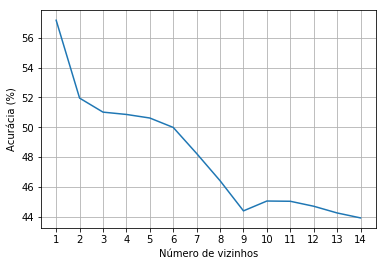

In [50]:
plt.show()